---
title: "Building a Solar Panel Detector"
author: "Devansh Lodha"
date: "2025-02-26"
description: "Building a computer vision system that can spot solar panels from the sky!"
categories: [code, object detection, computer vision]
image: "solar_panels.png"
jupyter: python3
format: html
bibliography: references.bib
---

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration and Understanding

**Dataset Overview**  
This solar panel detection dataset features 31 cm resolution aerial imagery with 2,542 meticulously labeled objects. The structure enables both computer vision tasks and precise geospatial analysis through carefully designed components:

**Label-Image Relationships**  
- Each 416×416 pixel image chip (`.tif`) pairs with a corresponding `.txt` label file  
- Consistent naming convention:  
  `[dataset]_[imagetype]_[tileID]_x[minX]_y[minY]_dxdy[windowSize]`  
  *Example pair:*  
  `solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif` (image) ↔  
  `solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt` (label)  

**Annotation Format**  
Each label file contains rows with:  
`category x_center y_center x_width y_width`

- Coordinates normalized to 0-1 range relative to 416px image chips  
- One row per solar panel object  
- Standardized category IDs for consistent classification 

In [37]:
images_path = "data/images"
labels_path = "data/labels"

In [38]:
len([image_path for image_path in os.listdir(images_path) if image_path.endswith(".tif")]), len([label_path for label_path in os.listdir(labels_path) if label_path.endswith(".txt")])

(2542, 2542)

We observe and inconsistency between the number of images and the number of labels. Hence we will have to filter out the images which have no labels.

In [39]:
# delete images with no labels
for image_path in os.listdir(images_path):
    if image_path.endswith(".tif"):
        label_path = os.path.join(labels_path, image_path.replace(".tif", ".txt"))
        if not os.path.exists(label_path):
            os.remove(os.path.join(images_path, image_path))

In [40]:
len([image_path for image_path in os.listdir(images_path) if image_path.endswith(".tif")]), len([label_path for label_path in os.listdir(labels_path) if label_path.endswith(".txt")])

(2542, 2542)

### Dataset Statistics

We'll first calculate the total instances of solar panels in the dataset

In [41]:
total_instances = 0
labels_per_image = {}

for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            num_instances = len(lines)
            total_instances += num_instances
            labels_per_image[filename] = num_instances

print(f"Total instances of solar panels in the dataset: {total_instances}")

Total instances of solar panels in the dataset: 29625


Now we'll calculate value counts of labels per image

In [42]:
labels_counts = {}
for filename, count in labels_per_image.items():
    labels_counts[count] = labels_counts.get(count, 0) + 1

print("\nValue counts of labels per image:")
for count, num_images in sorted(labels_counts.items()):
    print(f"{num_images} images have {count} labels.")


Value counts of labels per image:
81 images have 1 labels.
167 images have 2 labels.
221 images have 3 labels.
218 images have 4 labels.
217 images have 5 labels.
189 images have 6 labels.
170 images have 7 labels.
184 images have 8 labels.
169 images have 9 labels.
121 images have 10 labels.
97 images have 11 labels.
84 images have 12 labels.
69 images have 13 labels.
49 images have 14 labels.
46 images have 15 labels.
41 images have 16 labels.
36 images have 17 labels.
25 images have 18 labels.
29 images have 19 labels.
14 images have 20 labels.
4 images have 21 labels.
1 images have 22 labels.
4 images have 23 labels.
2 images have 24 labels.
4 images have 25 labels.
3 images have 26 labels.
5 images have 27 labels.
5 images have 28 labels.
15 images have 29 labels.
20 images have 30 labels.
8 images have 31 labels.
7 images have 32 labels.
13 images have 33 labels.
19 images have 34 labels.
10 images have 35 labels.
6 images have 36 labels.
17 images have 37 labels.
13 images have

In [43]:
# calculate number of classes
classes = set()
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                classes.add(line.split()[0])

num_classes = len(classes)
print(f"The classes are {classes}.")
print(f"The number of classes is {num_classes}.")

The classes are {'1', '0', '2'}.
The number of classes is 3.


In [44]:
# count number of instances per class
class_counts = {class_name: 0 for class_name in classes}
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_name = line.split()[0]
                class_counts[class_name] += 1

print("\nValue counts of instances per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} instances.")


Value counts of instances per class:
1: 130 instances.
0: 29267 instances.
2: 228 instances.


Since the number of classes 1 and 2 are less, we'll map them to class 0 before training the model.

### Area of Solar Panels

Geospatial Conversion Process

To calculate solar panel areas, we first convert bounding box coordinates to real-world geographical coordinates using EPSG:32632 (WGS 84/UTM zone 33N).

##### Tile Reference Parameters

| Tile | Origin X    | Pixel Width | Origin Y     | Pixel Height |
|------|-------------|-------------|--------------|--------------|
| 1    | 307,670.04  | 0.31m       | 5,434,427.10 | -0.31m       |
| 2    | 312,749.08  | 0.31m       | 5,403,952.86 | -0.31m       |
| 3    | 312,749.08  | 0.31m       | 5,363,320.54 | -0.31m       |

*All coordinates in meters using EPSG:32633 projection*

##### Coordinate Conversion Pipeline

1. **Chip Coordinates**  
   Convert normalized coordinates to pixel positions:  
   $$
   x_{\text{chip}} = x_{\text{norm}} \times 416
   $$
   $$
   y_{\text{chip}} = y_{\text{norm}} \times 416
   $$

2. **Tile Coordinates**  
   Calculate absolute positions within tile:  
   $$
   x_{\text{tile}} = x_{\text{min}} + x_{\text{chip}}
   $$
   $$
   y_{\text{tile}} = y_{\text{min}} + y_{\text{chip}}
   $$

3. **Geographic Coordinates**  
   Transform to real-world coordinates:  
   $$
   X_{\text{geo}} = \text{OriginX} + x_{\text{tile}} \cdot \Delta x + y_{\text{tile}} \cdot \text{skew}_x
   $$
   $$
   Y_{\text{geo}} = \text{OriginY} + x_{\text{tile}} \cdot \text{skew}_y + y_{\text{tile}} \cdot \Delta y
   $$  
   Where $\Delta x = 0.31$m and $\Delta y = -0.31$m

##### Area Calculation

Calculate physical dimensions from pixel measurements:  
$$
\text{Width}_{\text{m}} = x_{\text{width}} \times |\Delta x| \\
\text{Height}_{\text{m}} = y_{\text{height}} times |\Delta y| \\
\text{Area}_{\text{m}^2} = \text{Width}_{\text{m}} \times \text{Height}_{\text{m}}
$$

##### Statistical Analysis

Final metrics computed using:  
$$
\mu_{\text{area}} = \frac{1}{n}\sum_{i=1}^{n} \text{Area}_i \\
\sigma_{\text{area}} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\text{Area}_i - \mu_{\text{area}})^2}
$$

This pipeline enables precise geospatial positioning and area calculation while maintaining sub-meter accuracy across all dataset tiles.\


Statistics of the area of solar panels in meters:
Mean area: 191.52 square meters
Standard deviation of area: 630.70 square meters


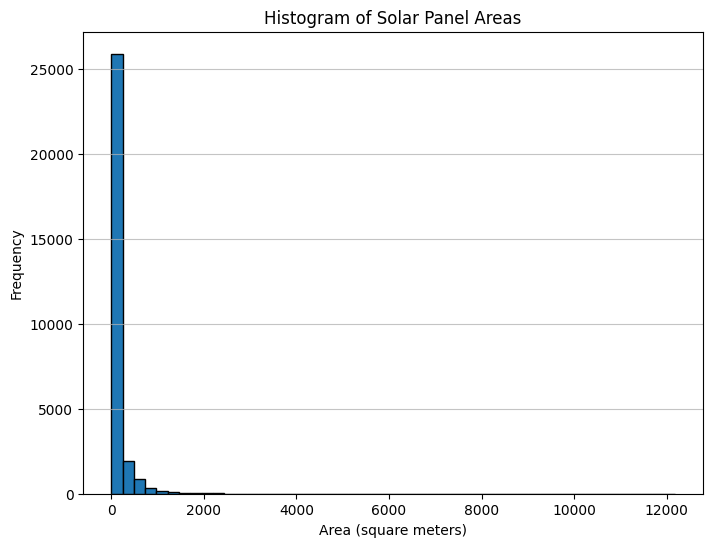

In [45]:
areas = []
geotransforms = {
    1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31),
    2: (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31),
    3: (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)
}
chip_size = 416

for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        parts = filename.split('_')
        tile_num = int(parts[2])
        xmin_chip = int(parts[5])
        ymin_chip = int(parts[7])
        dxdy = int(parts[9].split('.')[0]) # window size
        
        geotransform = geotransforms[tile_num]
        with open(filepath, 'r') as f:
            for line in f:
                category, x_center_norm, y_center_norm, x_width_norm, y_width_norm = map(float, line.strip().split())

                # Normalized to pixel coords in chip (416x416)
                x_center_chip = x_center_norm * chip_size
                y_center_chip = y_center_norm * chip_size
                x_width_chip = x_width_norm * chip_size
                y_width_chip = y_width_norm * chip_size

                # Chip coords to tile coords
                xmin_tile_px = xmin_chip
                ymin_tile_px = ymin_chip
                x_center_tile = xmin_tile_px + x_center_chip
                y_center_tile = ymin_tile_px + y_center_chip
                x_width_tile = x_width_chip
                y_width_tile = y_width_chip

                # Pixel coords to geocoords (EPSG:32633)
                x_geo = geotransform[0] + x_center_tile * geotransform[1] + y_center_tile * geotransform[2]
                y_geo = geotransform[3] + x_center_tile * geotransform[4] + y_center_tile * geotransform[5]
                x_geo_width = x_width_tile * geotransform[1] # width in meters
                y_geo_height = y_width_tile * abs(geotransform[5]) # height in meters (geotransform[5] is negative)

                area = x_geo_width * y_geo_height
                areas.append(area)

print("\nStatistics of the area of solar panels in meters:")
print(f"Mean area: {np.mean(areas):.2f} square meters")
print(f"Standard deviation of area: {np.std(areas):.2f} square meters")

# Histogram of areas
plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50, edgecolor='black')
plt.title('Histogram of Solar Panel Areas')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution is skewed, indicating that smaller solar panels are more frequent than larger ones.

## Implementing Fundamental Functions

In [46]:
from shapely.geometry import Polygon
import supervision as sv

### Intersection over Union (IoU)

Intersection over Union (IoU) is a metric that quantifies the degree of overlap between two regions.

#### Using Shapely

We use shapely's Polygon class to calculate the intersection over union of two bounding boxes. For this first we need a function to convert the bounding box coordinates to a polygon.

In [47]:
def yolo_to_polygon(box_yolo, img_w, img_h):
    _, x_center_norm, y_center_norm, width_norm, height_norm = box_yolo
    x_center = x_center_norm * img_w
    y_center = y_center_norm * img_h
    width = width_norm * img_w
    height = height_norm * img_h
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

def iou_shapely(box1_yolo, box2_yolo, image_width, image_height):
    _, x_center1_norm, y_center1_norm, width1_norm, height1_norm = box1_yolo
    _, x_center2_norm, y_center2_norm, width2_norm, height2_norm = box2_yolo

    poly1 = yolo_to_polygon(box1_yolo, image_width, image_height)
    poly2 = yolo_to_polygon(box2_yolo, image_width, image_height)

    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area
    if union_area == 0:
        return 0.0
    return intersection_area / union_area

#### Using Supervision

sv.Detections expects coordinates in xyxy format

In [98]:
def yolo_to_xyxy(box_yolo, img_w, img_h):
    try:
        _, x_center_norm, y_center_norm, width_norm, height_norm = box_yolo
    except ValueError:
        x_center_norm, y_center_norm, width_norm, height_norm = box_yolo
        
    x_center = x_center_norm * img_w
    y_center = y_center_norm * img_h
    width = width_norm * img_w
    height = height_norm * img_h
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return np.array([x_min, y_min, x_max, y_max])

def iou_supervision(box1_yolo, box2_yolo, image_width, image_height):
    box1_xyxy = yolo_to_xyxy(box1_yolo, image_width, image_height)
    box2_xyxy = yolo_to_xyxy(box2_yolo, image_width, image_height)

    detections1 = sv.Detections(xyxy=box1_xyxy[np.newaxis, :], confidence=np.array([1.0]), class_id=np.array([0]))
    detections2 = sv.Detections(xyxy=box2_xyxy[np.newaxis, :], confidence=np.array([1.0]), class_id=np.array([0]))

    iou_matrix = sv.box_iou_batch(detections1.xyxy, detections2.xyxy) # pairwise IoU between boxes
    return iou_matrix[0, 0] if iou_matrix.size > 0 else 0.0

#### Comparing IoUs

Comparing the IoU values calculated using Shapely and Supervision on an example set of bounding boxes for an image of size 100.

In [49]:
image_size = 100
box1_yolo = [0, 0.5, 0.5, 0.2, 0.2] # category, x_center_norm, y_center_norm, x_width_norm, y_width_norm
box2_yolo = [0, 0.6, 0.6, 0.2, 0.2]

iou_shapely_val = iou_shapely(box1_yolo, box2_yolo, image_size, image_size)
iou_supervision_val = iou_supervision(box1_yolo, box2_yolo, image_size, image_size)

print(f"\nIoU using shapely: {iou_shapely_val:.4f}")
print(f"IoU using supervision: {iou_supervision_val:.4f}")


IoU using shapely: 0.1429
IoU using supervision: 0.1429


The IoU values from shapely and supervision are the same!

### Average Precision (AP)

Essentially, IoU is a measure of how well the predicted bounding box overlaps with the ground truth bounding box. We set a threshold for the IoU value, and if the IoU value is greater than the threshold, we consider the prediction to be a True Positive. Otherwise, it is a False Positive. We consider all target boxes for which there is no prediction as False Negatives. There is no True Negative in this case.

Precision measures the proportion of predicted positives that are actually correct Mathematically, it’s defined as follows. <br>
$$P  =  \frac{TP}{TP + FP}$$

Recall measures the proportion of actual positives that were predicted correctly. It is the True Positives out of all Ground Truths. Mathematically, it is defined as follows. <br>
$$R = \frac{TP}{TP + FN}$$

Average Precision (AP) is not the average of Precision (P), it is the area under the precision-recall curve.

We first sort the detections per class by their confidence scores in descending order. We then calculate precision and recall using the cumulative TP and FP values going down the sorted list. We plot these precision (y-axis) and recall (x-axis) values to get the precision-recall curve. The AP is the area under this curve.

#### Pascal VOC 11 point interpolation method

The 11 point interpolation method was introduced in the 2007 PASCAL VOC challenge.

AP averages precision at a set of 11 spaced recall points (0, 0.1, 0.2, .. , 1) where we interpolate the corresponding precision for a certain recall value r by taking the maximum precision whose recall value $\tilde r>r$

In other words, take the maximum precision point where its corresponding recall value is to the right of $r$. In this case, precision is interpolated at 11 recall levels, hence the name 11-point interpolated average precision.

This is particularly useful as it reduces the variations in the precision x recall curve. This interpolated precision is referred to as $p_{interp}(r)$.

$$AP=\frac{1}{11}\sum_{r \in \{0,0.1,0.2,...,1\}}p_{interp}(r)$$
where
$$p_{interp}(r)=\underset{\tilde r > r} {\text{max }} p(\tilde r)$$

We can construct an example to see this in action. I've defined a function `voc_interpolation_11point` that takes in the precision and recall values and returns the interpolated precision values. The intention in interpolating the precision/recall curve in this way is to reduce the impact of the “wiggles” in the precision/recall curve, caused by small variations in the ranking of examples.

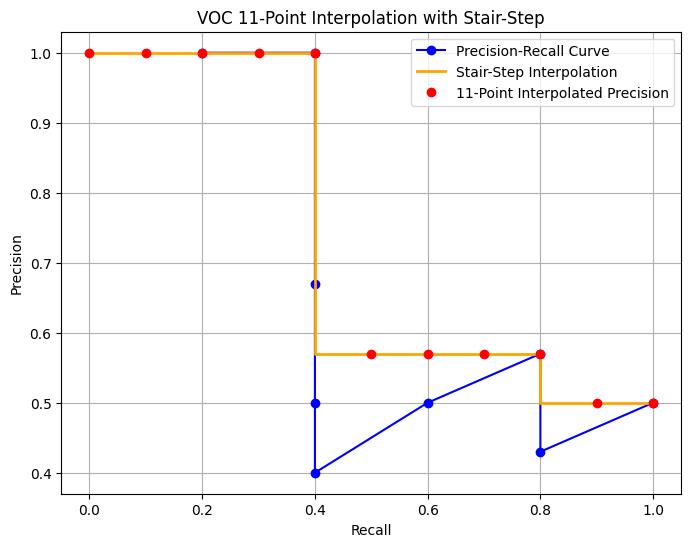

In [50]:
def voc_interpolation_11point(precisions, recalls):
    voc_recall_points = np.linspace(0, 1, 11)
    interpolated_precisions = []
    for r in voc_recall_points:
        mask = recalls >= r
        if np.any(mask):
            interpolated_precisions.append(np.max(precisions[mask]))
        else:
            interpolated_precisions.append(0.0)  # or could be np.nan
    return voc_recall_points, np.array(interpolated_precisions)

# Sample Precision-Recall curve data
recalls = np.array([0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 1.0])
precisions = np.array([1.0, 1.0, 0.67, 0.5, 0.4, 0.5, 0.57, 0.43, 0.5])

# Calculate interpolated precision points
interpolation_points_recall, interpolated_precisions = voc_interpolation_11point(precisions, recalls)

# Plot the Precision-Recall curve and stair-step interpolation
plt.figure(figsize=(8, 6))

# Original Precision-Recall curve
plt.plot(recalls, precisions, marker='o', linestyle='-', color='blue', label='Precision-Recall Curve')

# Stair-step plot for interpolated precision
plt.step(interpolation_points_recall, interpolated_precisions, where='pre', color='orange', label='Stair-Step Interpolation', linewidth=2)

# Interpolated precision points
plt.plot(interpolation_points_recall, interpolated_precisions, 'o', color='red', label='11-Point Interpolated Precision')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('VOC 11-Point Interpolation with Stair-Step')
plt.legend()
plt.grid(True)
plt.show()

Say $[r_1,...,r_{11}]$ are the 11 recall levels. Then AP which the area under the curve is simply sum of areas of rectangels formed after plotting the stair-step interpolated curve.
$$AP = \sum (r_{i}-r_{i-1})p_{interp}(r_{i})$$

This area calculation is more precisely achieved by `np.trapezoid` which essentialy performs numerical integration.

In [53]:
def average_precision_voc11(precisions, recalls):
    voc_recall_points = np.linspace(0, 1, 11)
    interpolated_precisions = []
    # we do step-wise interpolation
    for r in voc_recall_points:
        mask = recalls >= r
        if np.any(mask):
            interpolated_precisions.append(np.max(precisions[mask]))
        else:
            interpolated_precisions.append(0.0) # or could be np.nan, depending on handling
    return np.trapezoid(interpolated_precisions, voc_recall_points)

#### COCO 101-point interpolation method

This is similar to VOC 11-point interpolation except we use 101 points and perform linear interpolation.

In [54]:
def average_precision_coco101(precisions, recalls):
    coco_recall_points = np.linspace(0, 1, 101)
    # we do linear interpolation hence using np.interp works
    interpolated_precisions = np.interp(coco_recall_points, recalls, precisions, left=0, right=0)
    return np.trapezoid(interpolated_precisions, coco_recall_points)

#### Area under Precision-Recall Curve (AP) method

Here we directly use `np.trapezoid`.

In [55]:
def average_precision_auc(precisions, recalls):
    return np.trapezoid(precisions, recalls) # Note the order: y=precisions, x=recalls

#### Comparing AP50s

In [56]:
import random

In [57]:
def generate_random_detections(num_images=10, image_size=100, box_size=20):
    all_true_boxes = []
    all_pred_boxes = []
    all_scores = []
    for _ in range(num_images):
        true_boxes_img = []
        pred_boxes_img = []
        scores_img = []
        for _ in range(10): # 10 boxes per image
            # Ground truth box
            x_center_gt = random.uniform(0.2, 0.8) # center within image
            y_center_gt = random.uniform(0.2, 0.8)
            true_box = [0, x_center_gt, y_center_gt, box_size/image_size, box_size/image_size]
            true_boxes_img.append(true_box)

            # Predicted box (slightly shifted from GT for some overlap)
            x_center_pred = x_center_gt + random.uniform(-0.1, 0.1)
            y_center_pred = y_center_gt + random.uniform(-0.1, 0.1)
            pred_box = [0, max(0.01, min(0.99, x_center_pred)), max(0.01, min(0.99, y_center_pred)), box_size/image_size, box_size/image_size] # clamp to avoid boxes outside image
            pred_boxes_img.append(pred_box)
            scores_img.append(random.uniform(0.5, 1.0)) # Assign some confidence score

        all_true_boxes.append(true_boxes_img)
        all_pred_boxes.append(pred_boxes_img)
        all_scores.append(scores_img)
    return all_true_boxes, all_pred_boxes, all_scores

In [95]:
def compute_ap_and_pr(true_boxes_list, pred_boxes_list, scores_list, iou_threshold=0.5, image_size=416):
    all_predictions = []
    total_gt_boxes = sum(len(boxes) for boxes in true_boxes_list)
    
    for img_idx, (true_boxes, pred_boxes, scores) in enumerate(zip(true_boxes_list, pred_boxes_list, scores_list)):
        for pred_idx, (pred_box, score) in enumerate(zip(pred_boxes, scores)):
            all_predictions.append({
                'img_idx': img_idx,
                'pred_idx': pred_idx,
                'score': score
            })
    
    # Sort all predictions by confidence (highest first)
    all_predictions.sort(key=lambda x: x['score'], reverse=True)
    
    # Track which GT boxes have been matched
    gt_matched = [np.zeros(len(boxes), dtype=bool) for boxes in true_boxes_list]
    
    # Calculate precision and recall
    tp = 0
    fp = 0
    precisions = []
    recalls = []
    
    for pred in all_predictions:
        img_idx = pred['img_idx']
        pred_idx = pred['pred_idx']
        
        # Get prediction and ground truth boxes for this image
        true_boxes = true_boxes_list[img_idx]
        pred_box = pred_boxes_list[img_idx][pred_idx]
        
        # Find best matching GT box
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx, gt_box in enumerate(true_boxes):
            if not gt_matched[img_idx][gt_idx]:
                # Calculate IoU between prediction and this GT box
                iou = iou_supervision(pred_box, gt_box, image_size, image_size)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
        
        # Check if match is good enough
        if best_gt_idx >= 0 and best_iou >= iou_threshold:
            tp += 1
            gt_matched[img_idx][best_gt_idx] = True  # Mark this GT as matched
        else:
            fp += 1
        
        # Calculate precision and recall at this point
        precision = tp / (tp + fp)
        recall = tp / total_gt_boxes
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.array(precisions), np.array(recalls)

In [96]:
random_true_boxes, random_pred_boxes, random_scores = generate_random_detections()

iou_threshold_ap50 = 0.5
precisions, recalls = compute_ap_and_pr(random_true_boxes, random_pred_boxes, random_scores, iou_threshold=iou_threshold_ap50)

In [97]:
ap_voc11 = average_precision_voc11(precisions, recalls)
ap_coco101 = average_precision_coco101(precisions, recalls)
ap_auc_val = average_precision_auc(precisions, recalls)

print(f"\nAP50 using Pascal VOC 11-point interpolation: {ap_voc11:.4f}")
print(f"AP50 using COCO 101-point interpolation: {ap_coco101:.4f}")
print(f"AP50 using PR-AUC: {ap_auc_val:.4f}")


AP50 using Pascal VOC 11-point interpolation: 0.2238
AP50 using COCO 101-point interpolation: 0.1837
AP50 using PR-AUC: 0.1843


## Model building and evaluation

In [1]:
import shutil
from ultralytics import YOLO
from PIL import Image  # Required for image conversion
import pandas as pd
import seaborn as sns   

#### Preparing data

In [ ]:
def prepare_data(base_path):
    orig_images = os.path.join(base_path, "images")
    orig_labels = os.path.join(base_path, "labels")
    
    # Create new directories for converted dataset
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(base_path, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(base_path, split, "labels"), exist_ok=True)

    # Get all label files
    label_files = [f for f in os.listdir(orig_labels) if f.endswith(".txt")]
    
    # Shuffle and split
    random.seed(42)
    random.shuffle(label_files)
    total = len(label_files)
    train_split = int(0.8 * total)
    val_split = int(0.1 * train_split)
    
    # Split files
    train_files = label_files[:train_split - val_split]
    val_files = label_files[train_split - val_split:train_split]
    test_files = label_files[train_split:]

    def process_split(files, split_name):
        dest_img = os.path.join(base_path, split_name, "images")
        dest_lbl = os.path.join(base_path, split_name, "labels")

        for lbl_file in files:
            # Original paths
            tif_path = os.path.join(orig_images, lbl_file.replace(".txt", ".tif"))
            txt_path = os.path.join(orig_labels, lbl_file)
            
            # New paths
            png_path = os.path.join(dest_img, lbl_file.replace(".txt", ".png"))
            new_label_path = os.path.join(dest_lbl, lbl_file)
            
            # Convert image
            with Image.open(tif_path) as img:
                img.save(png_path, "PNG")
            
            # Map classes 1,2 to 0
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            
            corrected = []
            for line in lines:
                parts = line.strip().split()
                if parts:  # Skip empty lines
                    # Map classes 1 and 2 to 0
                    if parts[0] in ['1', '2']:
                        parts[0] = '0'
                    corrected.append(' '.join(parts) + '\n')
            
            # Write corrected labels
            with open(new_label_path, 'w') as f:
                f.writelines(corrected)

    # Process all splits
    process_split(train_files, "train")
    process_split(val_files, "val")
    process_split(test_files, "test")

    # Print final counts
    print(f"Dataset prepared with class mapping:")
    print(f"Total samples: {total}")
    print(f"Train: {len(train_files)} ({len(train_files)/total:.1%})")
    print(f"Validation: {len(val_files)} ({len(val_files)/total:.1%})")
    print(f"Test: {len(test_files)} ({len(test_files)/total:.1%})")
    print("All classes 1 and 2 have been mapped to 0")

prepare_data("./data")

Dataset prepared with class mapping:
Total samples: 2542
Train: 1830 (72.0%)
Validation: 203 (8.0%)
Test: 509 (20.0%)
All classes 1 and 2 have been mapped to 0


In [28]:
# Create data directory if it doesn't exist
base_path = os.path.abspath('./data')

# Create YAML content with absolute paths
data_yaml_content = f"""path: {base_path}
train: {os.path.join(base_path, 'train', 'images')}
val: {os.path.join(base_path, 'val', 'images')}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1
names: ['solar_panel']
"""

# Write to data.yaml
with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
    f.write(data_yaml_content)

print(f"data.yaml created at:\n{os.path.join(base_path, 'data.yaml')}")
print("\nFile content:")
print(data_yaml_content)

data.yaml created at:
/Users/devanshlodha/Documents/IIT Gandhinagar/SRIP/Task/satellite-solar-panel-detection/data/data.yaml

File content:
path: /Users/devanshlodha/Documents/IIT Gandhinagar/SRIP/Task/satellite-solar-panel-detection/data
train: /Users/devanshlodha/Documents/IIT Gandhinagar/SRIP/Task/satellite-solar-panel-detection/data/train/images
val: /Users/devanshlodha/Documents/IIT Gandhinagar/SRIP/Task/satellite-solar-panel-detection/data/val/images
test: /Users/devanshlodha/Documents/IIT Gandhinagar/SRIP/Task/satellite-solar-panel-detection/data/test/images

nc: 1
names: ['solar_panel']



#### Model building

In [29]:
import torch
if torch.backends.mps.is_available():
    print("MPS is available")
else:
    print("MPS is not available")

MPS is available


In [ ]:
model = YOLO('yolo11x.pt')

results = model.train(
    data="data/data.yaml",
    epochs=30,
    imgsz=416,
    batch=8,
    name="solarpanel_detector_yolo11",
    device="mps",
    project="models",
    nms_time_limit=5.0
)

#### Visualization

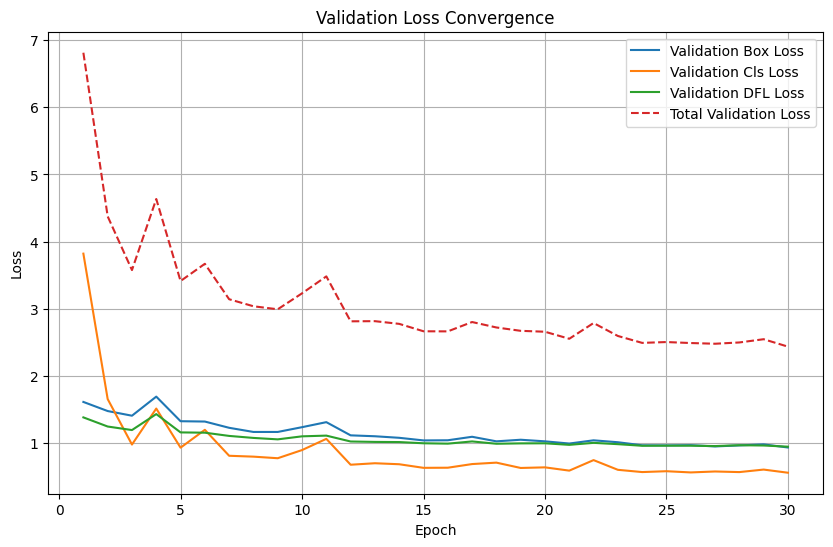

In [ ]:
df = pd.read_csv("models/solarpanel_detector_yolo113/results.csv")

# Calculate total validation loss
df['val/total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Cls Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Validation DFL Loss')
plt.plot(df['epoch'], df['val/total_loss'], label='Total Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()



0: 416x416 10 solar_panels, 88.8ms
Speed: 0.3ms preprocess, 88.8ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 solar_panels, 78.7ms
Speed: 0.3ms preprocess, 78.7ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 solar_panels, 80.9ms
Speed: 0.3ms preprocess, 80.9ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)


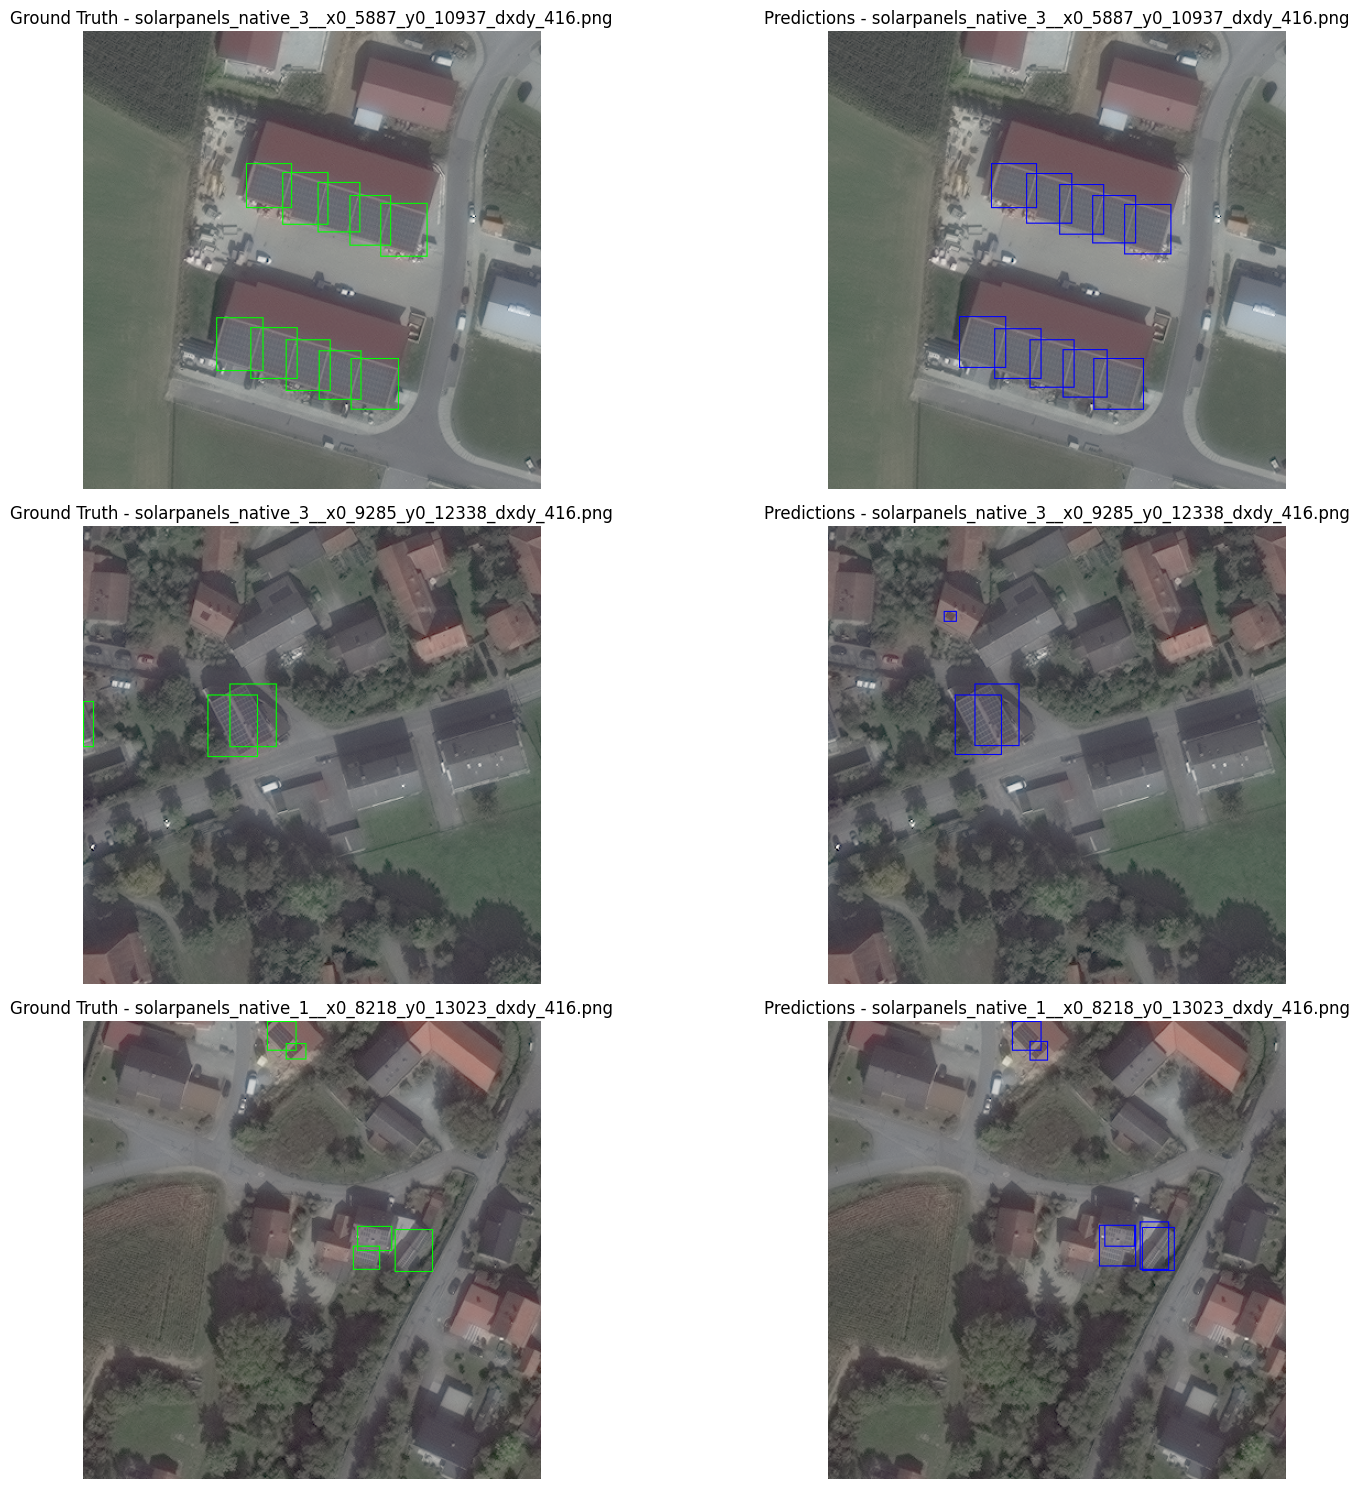

In [127]:
model = YOLO("models/solarpanel_detector_yolo113/weights/best.pt")

# Get a few random test images
test_images_dir = os.path.join(base_path, "test", "images") 
test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith('.png')]
random_test_images = random.sample(test_image_files, 3)  # 3 images

# create a figure with subplots
plt.figure(figsize=(18, 5 * len(random_test_images)))

for i, image_file in enumerate(random_test_images):
    image_path = os.path.join(test_images_dir, image_file)
    image = Image.open(image_path)
    img_w, img_h = image.size
    
    # get model predictions
    results = model(image)[0]
    
    # get ground truth boxes
    label_file = image_file.replace(".png", ".txt")
    label_path = os.path.join(base_path, "test", "labels", label_file)
    true_boxes = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                true_boxes.append([float(x) for x in parts])
        true_boxes = np.array(true_boxes)
    except FileNotFoundError:
        true_boxes = np.empty((0, 5))
    
    # Create detections objects
    if len(true_boxes) > 0:
        # Convert normalized YOLO boxes to absolute coords
        xyxy_boxes = np.array([yolo_to_xyxy(box, img_w, img_h) for box in true_boxes])
        
        detections_gt = sv.Detections(
            xyxy=xyxy_boxes,
            confidence=np.ones(len(true_boxes)),
            class_id=true_boxes[:, 0].astype(int)
        )
    else:
        detections_gt = sv.Detections(
            xyxy=np.empty((0, 4)),
            confidence=np.array([]),
            class_id=np.array([])
        )
    
    detections_pred = sv.Detections.from_ultralytics(results)
    
    # Create annotators with smaller line thickness
    box_annotator_gt = sv.BoxAnnotator(
        color=sv.Color.GREEN, 
        thickness=1 
    )
    
    box_annotator_pred = sv.BoxAnnotator(
        color=sv.Color.RED, 
        thickness=1  
    )
    
    # Ground Truth visualization
    annotated_image_gt = box_annotator_gt.annotate(
        scene=np.array(image), 
        detections=detections_gt
    )
    
    # Prediction visualization
    annotated_image_pred = box_annotator_pred.annotate(
        scene=np.array(image), 
        detections=detections_pred
    )

    # Plot side by side
    plt.subplot(len(random_test_images), 2, i*2 + 1)
    plt.imshow(annotated_image_gt)
    plt.title(f"Ground Truth - {image_file}")
    plt.axis('off')
    
    plt.subplot(len(random_test_images), 2, i*2 + 2)
    plt.imshow(annotated_image_pred)
    plt.title(f"Predictions - {image_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Evaluation

Let us first get the predictions for the test set.

In [ ]:
# Load the model
model = YOLO("models/solarpanel_detector_yolo113/weights/best.pt")

# Define the base path for the dataset
base_path = "./data"  # Adjust this if your data directory is located elsewhere

# Get a list of all image files in the test directory
test_images_dir = os.path.join(base_path, "test", "images")
test_image_files = [
    f for f in os.listdir(test_images_dir) if f.endswith((".png"))
]

def load_annotations(image_file, base_path):
    label_file = image_file.replace(
        os.path.splitext(image_file)[1], ".txt"
    ) 
    label_path = os.path.join(base_path, "test", "labels", label_file)
    image_path = os.path.join(test_images_dir, image_file)
    image = Image.open(image_path)
    img_w, img_h = image.size

    true_boxes = []

    with open(label_path, "r") as f:
        for line in f:
            true_boxes.append([float(x) for x in line.strip().split()])
    true_boxes = np.array(true_boxes)

    xyxy_boxes = np.array(
        [yolo_to_xyxy(box, img_w, img_h) for box in true_boxes]
    )
    detections = sv.Detections(
        xyxy=xyxy_boxes,
        confidence=np.ones(len(true_boxes)),
        class_id=true_boxes[:, 0].astype(int),
    )

    return detections


# Collect predictions and targets for all images
predictions = []
targets = []

for image_file in test_image_files:
    image_path = os.path.join(test_images_dir, image_file)
    image = Image.open(image_path)
    results = model(image, verbose = False)[0]
    detections = sv.Detections.from_ultralytics(results)
    predictions.append(detections)

    # Load corresponding annotations
    target_detections = load_annotations(image_file, base_path)
    targets.append(target_detections)

Now we use our method to calculate the AP50 for the test set.

In [103]:
# Compute mAP50 using our functions
precisions, recalls = compute_ap_and_pr(
    true_boxes_list = [t.xyxy for t in targets], 
    pred_boxes_list = [p.xyxy for p in predictions], 
    scores_list = [p.confidence for p in predictions],
    iou_threshold=0.5,      
    image_size=416
)

average_precision_auc(precisions, recalls)

np.float64(0.9490736432683332)

Now testing if we get similar results using the supervision's `compute_average_precision` function.

In [106]:
mean_average_precision = sv.MeanAveragePrecision.compute_average_precision(
    recalls,
    precisions,
)

print(mean_average_precision)

0.9632529279292138


Now we make a heatmap of precision, recall and f1-score

Precision Table (rows=IoU thresholds, columns=Confidence thresholds):
     Conf=0.1  Conf=0.3  Conf=0.5  Conf=0.7  Conf=0.9
0.1     0.956     0.948     0.896     0.742     0.077
0.3     0.954     0.946     0.895     0.742     0.077
0.5     0.942     0.934     0.885     0.739     0.077
0.7     0.882     0.874     0.841     0.725     0.077
0.9     0.396     0.396     0.392     0.375     0.073

Recall Table (rows=IoU thresholds, columns=Confidence thresholds):
     Conf=0.1  Conf=0.3  Conf=0.5  Conf=0.7  Conf=0.9
0.1     0.787     0.818     0.927     0.985     1.000
0.3     0.785     0.817     0.925     0.985     1.000
0.5     0.775     0.806     0.916     0.981     0.998
0.7     0.725     0.754     0.870     0.962     0.998
0.9     0.326     0.342     0.405     0.498     0.954

F1-Score Table (rows=IoU thresholds, columns=Confidence thresholds):
     Conf=0.1  Conf=0.3  Conf=0.5  Conf=0.7  Conf=0.9
0.1     0.863     0.878     0.911     0.847     0.143
0.3     0.861     0.877     0.910   

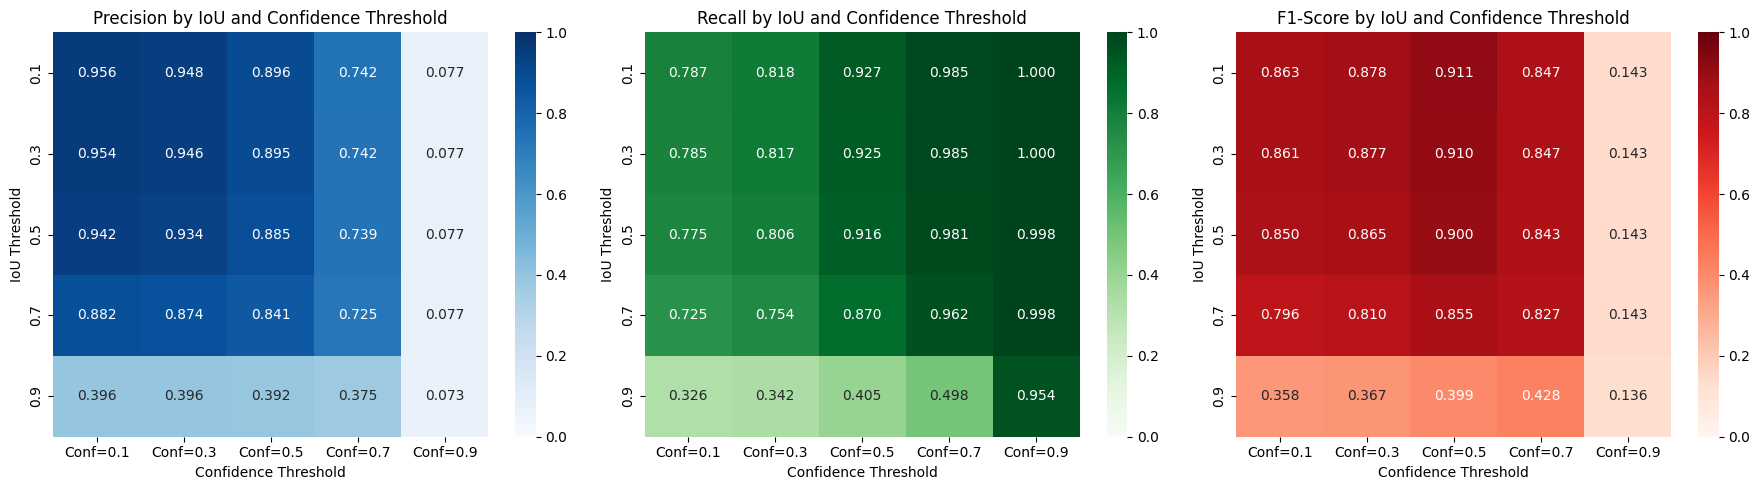

In [ ]:
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Initialize dictionaries to store metrics
precision_table = {}
recall_table = {}
f1_table = {}

for iou_threshold in iou_thresholds:
    precision_row = []
    recall_row = []
    f1_row = []
    
    for conf_threshold in conf_thresholds:
        
        confusion_matrix = sv.ConfusionMatrix.from_detections(
            predictions=predictions,
            targets=targets,
            classes=["solar_panel"],
            conf_threshold=conf_threshold,  
            iou_threshold=iou_threshold     
        )
        
        # get TP, FP, FN
        tp = confusion_matrix.matrix[0][0]
        fp = confusion_matrix.matrix[0][1]
        fn = confusion_matrix.matrix[1][0]
        
        # Calculate metrics, avoiding division by zero
        if tp + fp > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
            
        if tp + fn > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
            
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0
            
        precision_row.append(precision)
        recall_row.append(recall)
        f1_row.append(f1)
    
    # Store rows in the tables
    precision_table[iou_threshold] = precision_row
    recall_table[iou_threshold] = recall_row
    f1_table[iou_threshold] = f1_row


precision_df = pd.DataFrame(precision_table, index=conf_thresholds).T
recall_df = pd.DataFrame(recall_table, index=conf_thresholds).T
f1_df = pd.DataFrame(f1_table, index=conf_thresholds).T

precision_df.columns = [f'Conf={c}' for c in conf_thresholds]
recall_df.columns = [f'Conf={c}' for c in conf_thresholds]
f1_df.columns = [f'Conf={c}' for c in conf_thresholds]

# Display the tables
print("Precision Table (rows=IoU thresholds, columns=Confidence thresholds):")
print(precision_df.round(3))
print("\nRecall Table (rows=IoU thresholds, columns=Confidence thresholds):")
print(recall_df.round(3))
print("\nF1-Score Table (rows=IoU thresholds, columns=Confidence thresholds):")
print(f1_df.round(3))

# Optional: Visualize the tables as heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(precision_df, annot=True, cmap='Blues', fmt='.3f', vmin=0, vmax=1)
plt.title('Precision by IoU and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('IoU Threshold')

plt.subplot(1, 3, 2)
sns.heatmap(recall_df, annot=True, cmap='Greens', fmt='.3f', vmin=0, vmax=1)
plt.title('Recall by IoU and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('IoU Threshold')

plt.subplot(1, 3, 3)
sns.heatmap(f1_df, annot=True, cmap='Reds', fmt='.3f', vmin=0, vmax=1)
plt.title('F1-Score by IoU and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('IoU Threshold')

plt.tight_layout()
plt.show()